In [137]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
#%matplotlib notebook

#Parity Check matrix
H = np.array([
    [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
], dtype=int)


def getSyndrome(m, H):
    return m @ H.transpose() % 2

def isCorrect(m, H):
    return (getSyndrome(m, H) == 0).all()    

def bitWord(n, k):
    result = np.zeros((1, k), dtype=int)
    for i in range(k):
        result[0, i] = n % 2
        n //= 2
    return result

def intFromBitWord(word):
    assert(len(word.shape) <= 2)
    
    if len(word.shape) > 1:
        if word.shape[0] > 1:
            word = word.transpose()
        word = word[0]
    
    n = len(word)
        
    result = 0
    pow = 1
    for i in range(n - 1, -1, -1):
        result += word[i] * pow
        pow *= 2
    return result

In [138]:
def speed(H):
    r, n = H.shape
    k = n - r
    print("r =", r, " n =", n, " k =", k)
    return k / n

print("Speed of the code is:", speed(H))

r = 4  n = 10  k = 6
Speed of the code is: 0.6


In [139]:
import itertools

def hasDLinearlyDependentColumns(H, d):
    r, n = H.shape
    
    allColumns = range(0, n)
    
    for columns in itertools.combinations(allColumns, d):
        a = np.zeros(r, dtype=int)
        for column in columns:
            a += H[:, column].transpose()
            a = a % 2
        if (a == 0).all():
            print("Linearly dependent columns are:", columns)
            return True
    return False

def hamming(H):
    r, n = H.shape
    for d in range(2, n):
        if hasDLinearlyDependentColumns(H, d):
            return d
    return n

print("Hamming distance of the code is:", hamming(H))

Linearly dependent columns are: (0, 1, 4)
Hamming distance of the code is: 3


In [140]:
def getGFromH(H):
    H = H.copy()
    
    r, n = H.shape
    k = n - r
    
    # Convert H to a form (P', I(r))
    for i in range(r):
        # Search for a row with 1 in column i + k
        selectedRow = -1
        for j in range(i, r):
            if H[j][i + k] == 1:
                selectedRow = j
                break
                
        # Swap selected row with current row
        H[[selectedRow, i], :] = H[[i, selectedRow], :]
        
        # Make all rows below this one 0 in current column
        for j in range(i + 1, r):
            if H[j, i + k] == 1:
                H[j, :] += H[i, :]
                H[j, :] %= 2
    for i in range(r - 1, -1, -1):
        # Make all rows above this one 0 in current column
        for j in range(i - 1, -1, -1):
            if H[j, i + k] == 1:
                H[j, :] += H[i, :]
                H[j, :] %= 2
    
    # Extract P from a H that was converted to (P', I(r))
    # And construct G in form of (I(k), P)
    P = H[:,:k].transpose()
    G = np.append(np.identity(k, dtype=int), P, axis=1)
    return G
    
G = getGFromH(H)
assert(isCorrect(G, H))
print("The generative matrix G is:")
print(G)
print()
print("An I(6) is it's information aggregate. The rest of the matrix is used for error correction.")

The generative matrix G is:
[[1 0 0 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 1 1 1]
 [0 0 0 1 0 0 1 1 0 0]
 [0 0 0 0 1 0 1 1 1 1]
 [0 0 0 0 0 1 0 0 1 1]]

An I(6) is it's information aggregate. The rest of the matrix is used for error correction.


In [141]:
def encode(message, G=G):
    return message @ G % 2

message = 3
word = bitWord(message, 6)
print("Message =", message, "| Which in binary is", word)

encodedMessage = encode(word)
assert(isCorrect(encodedMessage, H))
print("Encoded message is", encodedMessage)

Message = 3 | Which in binary is [[1 1 0 0 0 0]]
Encoded message is [[1 1 0 0 0 0 1 1 1 1]]


In [142]:
def getSyndromeMatrix(H):
    r, n = H.shape
    
    # Cardinality of errors vector.
    errorCnt = 2 ** r
    
    syndromeMatrix = np.zeros((errorCnt, n), dtype=int)
    errorWeights = np.full(errorCnt, -1, dtype=int)
    for i in range(2 ** n):
        error = bitWord(i, n)
        syndrome = getSyndrome(error, H)
        syndromeId = intFromBitWord(syndrome)
        
        weight = np.sum(error)
        
        if weight < errorWeights[syndromeId] or errorWeights[syndromeId] == -1:
            errorWeights[syndromeId] = weight
            syndromeMatrix[syndromeId, :] = error
    
    assert((errorWeights != -1).all())
    
    return syndromeMatrix

S = getSyndromeMatrix(H)
print("Syndrome matrix is:")
print(S)

Syndrome matrix is:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 0]]


In [143]:
def getMinimalSpanForm(A):
    A = A.copy()
    
    m, n = A.shape
    r = n - m
    
    #Make all rows have a different beginning
    for i in range(m):
        # Seanch for a row with 1 in column i
        selectedRow = -1
        for j in range(i, m):
            if A[j][i] == 1:
                selectedRow = j
                break
                
        # Swap selected row with cunnent row
        A[[selectedRow, i], :] = A[[i, selectedRow], :]
        
        # Make all rows below this one 0 in column i
        for j in range(i + 1, m):
            if A[j, i] == 1:
                A[j, :] += A[i, :]
                A[j, :] %= 2
    
    #Make all rows have a different ending
    ends = np.full(m, -1, dtype=int)
    for i in range(m - 1, -1, -1):
        
        pos = n - 1
        while A[i][pos] == 0:
            pos -= 1
        ends[i] = pos

        for j in range(i - 1, -1, -1):
            if A[j, pos] == A[i][pos]:
                A[j, :] += A[i, :]
                A[j, :] %= 2
    
    begins = np.full(m, -1, dtype=int)
    for i in range(m):
        pos = 0
        while A[i][pos] == 0:
            pos += 1
        begins[i] = pos 
                
    return A, begins, ends

def getComplexityProfile(MSF, begins, ends):
    m, n = MSF.shape
    assert(len(begins) == m and len(ends) == m)
    
    activeCnt = 0
    profile = [1]
    for j in range(n):
        activeCnt += np.count_nonzero(begins == j)
        activeCnt -= np.count_nonzero(ends == j)
        profile.append(2 ** activeCnt)
    return profile

MSF, begins, ends = getMinimalSpanForm(G)
print("Minimal Span Form(MSF) of the generator matrix G is:")
print(MSF)
print()
print("It's complexity profile is:", getComplexityProfile(MSF, begins, ends))

Minimal Span Form(MSF) of the generator matrix G is:
[[1 1 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 0 0 0 1 0]
 [0 0 1 0 1 0 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 1 1]]

It's complexity profile is: [1, 2, 4, 8, 16, 16, 16, 8, 4, 2, 1]


Decoding graph from generator matrix G:


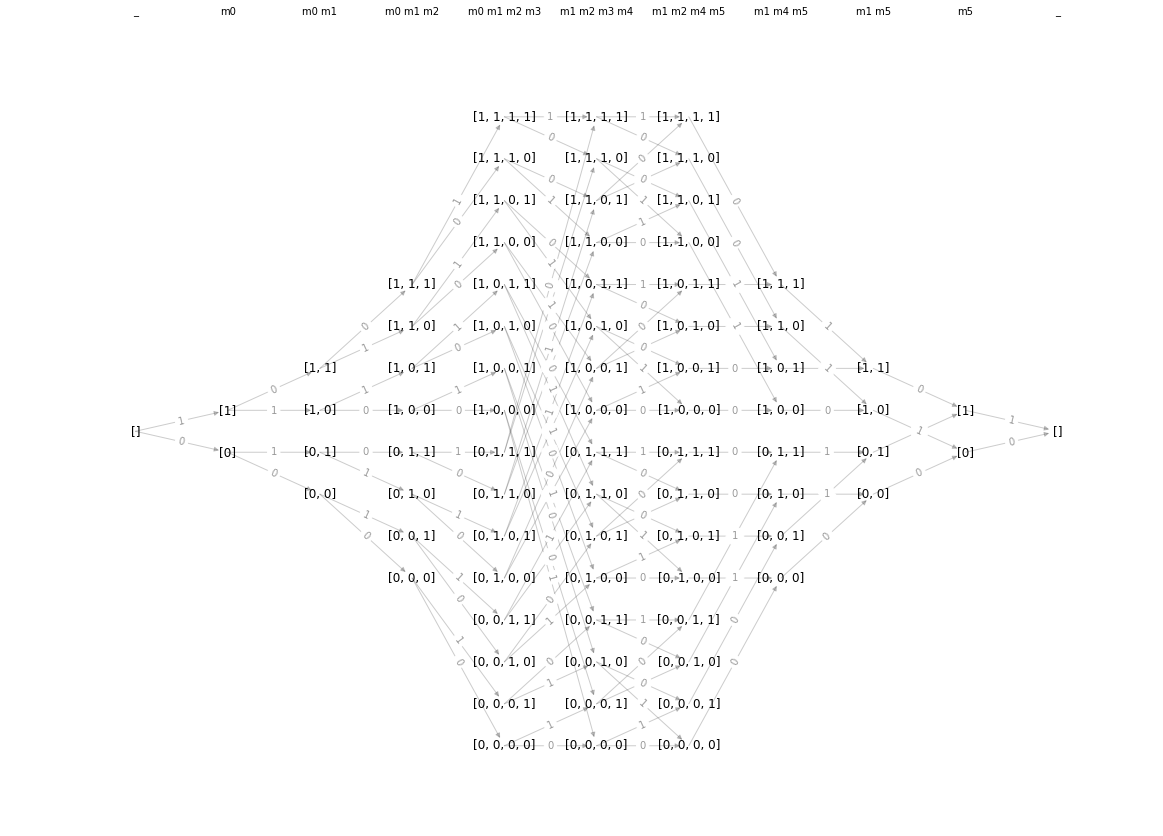

In [144]:
import networkx as nx
import matplotlib.pyplot as plt

class GNode:
    def __init__(self, x, y, active):
        self.x = x
        self.y = y
        self.active = active

    def joinToWord(self, other, m):
        result = np.zeros(m, dtype=int)
        #Join two Nodes
        active = {**self.active, **other.active}
        for key, value in active.items():
            result[key] = value
        return result

    def __str__(self):
        return str(list(self.active.values()))

    def __hash__(self):
        return hash((self.x, str(self.active)))

    def __eq__(self, other):
        return self.active == other.active and self.x == other.x

def getGraphFromGeneratorMatrix(G, plot=True):
    G, begins, ends = getMinimalSpanForm(G)
    profile = getComplexityProfile(G, begins, ends)

    graph = nx.DiGraph()
    labels = {}
    edgeLabels = {}
    pos = {}
    
    m, n = G.shape
    
    initialNode = GNode(-1, 0, {})
    graph.add_node(initialNode)
    labels[initialNode] = str(initialNode)
    pos[initialNode] = (-1, 0)
    
    previousLayer = [initialNode]
    actives = ["_"]
    
    
    for j in range(n):
        newLayer = []
        def addNode(previousNode, newDict):
            node = GNode(j, len(newLayer), newDict)
            
            transitionWord = node.joinToWord(previousNode, m)
            transitionLabel = (transitionWord @ G[:, j]) % 2
            
            graph.add_edge(previousNode, node)
            
            edgeLabels[(previousNode, node)] = transitionLabel
                
            if node not in labels:
                newLayer.append(node)
                labels[node] = str(node)
        
        for previousNode in previousLayer:
            active = previousNode.active.copy()
            
            if (ends == j).any():
                i = np.argwhere(ends == j)[0][0]
                del active[i]
            
            if (begins == j).any():
                i = np.argwhere(begins == j)[0][0]
                active1 = active.copy()
                active1[i] = 0
                addNode(previousNode, active1)
                
                active2 = active.copy()
                active2[i] = 1
                addNode(previousNode, active2)
            else:
                addNode(previousNode, active)
            
        center = (len(newLayer) - 1) / 2
        for node in newLayer:
            pos[node] = (node.x, node.y - center)
        actives.append(str(" ".join(map(lambda x: "m"+str(x), newLayer[0].active.keys()))))
            
        previousLayer = newLayer

    if plot:
        plt.figure(figsize=(20,14))
        nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)
        nx.draw_networkx_labels(graph, pos, labels, font_weight=4)
        nx.draw_networkx_edge_labels(graph, pos, edgeLabels, alpha=0.4)

        actives[-1] = "_"
        for i, text in enumerate(actives):
            plt.text(i - 1, 10, text, horizontalalignment='center', verticalalignment='center')

        plt.axis('off');
        plt.show()
    return graph, edgeLabels
    
print("Decoding graph from generator matrix G:")
getGraphFromGeneratorMatrix(G);

Decoding graph created from a Parity-check matrix:


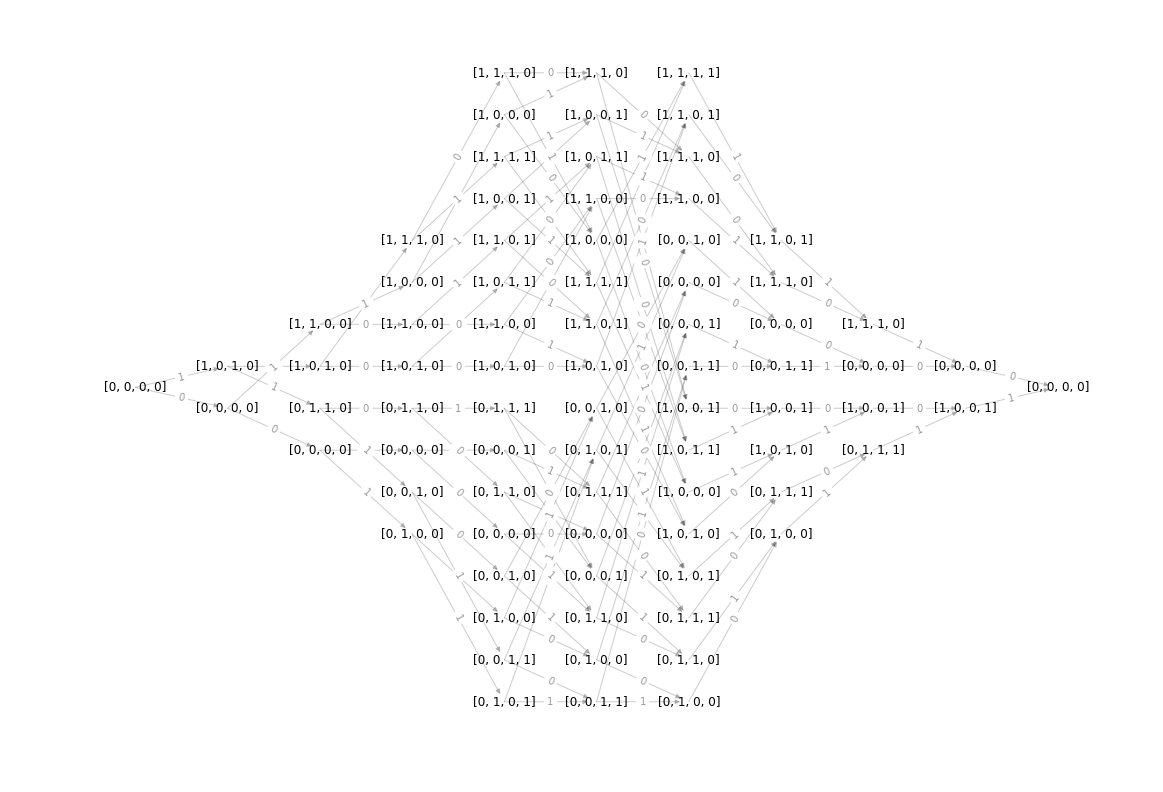

In [145]:
import networkx as nx
import matplotlib.pyplot as plt

def getGraphFromH(H, plot=True):
    graph = nx.DiGraph()
    labels = {}
    edgeLabels = {}
    
    r, n = H.shape
    
    class Node:
        def __init__(self, x, syndrome):
            self.x = x
            self.syndrome = np.array(syndrome, dtype=int)
        
        def __str__(self):
            return str(list(self.syndrome))

        def __hash__(self):
            return hash((self.x, str(self.syndrome)))

        def __eq__(self, other):
            return (self.syndrome == other.syndrome).all() and self.x == other.x
    
    initialNode = Node(-1, np.zeros(r, dtype=int))
    graph.add_node(initialNode)
    labels[initialNode] = str(initialNode)    
    
    previousLayer = {initialNode}
    for j in range(n):
        newLayer = set()
        def addNode(previousNode, symbol):
            syndrome = (previousNode.syndrome + symbol * H[:, j]) % 2
            node = Node(j, syndrome)
            
            graph.add_edge(previousNode, node)
            
            edgeLabels[(previousNode, node)] = symbol
                
            if node not in newLayer:
                newLayer.add(node)
                labels[node] = str(node)
        
        for previousNode in previousLayer:
                addNode(previousNode, 0)
                addNode(previousNode, 1)
            
        previousLayer = newLayer
        
    
    pos = {}
    height = [0] * (n + 1)
        
    reversedGraph = graph.reverse(copy=True)
    graph.clear()
    root = Node(n - 1, np.zeros(r, dtype=int))
    graph.add_node(root)
    pos[root] = (n - 1, 0)
    height[n] = 1

    used = set()
    def addAllChildren(root):
        for current, child in nx.edges(reversedGraph, root):
            assert(current == root)
            graph.add_edge(child, root)
            
            if child not in used:
                pos[child] = (child.x, height[child.x + 1])
                height[child.x + 1] += 1
                used.add(child)
            
            addAllChildren(child)
    addAllChildren(root)
    
    for node in list(labels.keys()):
        if node not in nx.nodes(graph):
            del labels[node]
            
    for root, child in list(edgeLabels.keys()):
        if root not in nx.nodes(graph) or child not in nx.nodes(graph):
            del edgeLabels[(root, child)]
    
    if plot:
        for node in list(pos.keys()):
            x, y = pos[node]
            pos[node] = (x, y - (height[node.x + 1]) / 2);

        plt.figure(figsize=(20, 14))
        nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)
        nx.draw_networkx_labels(graph, pos, labels, font_weight=4)
        nx.draw_networkx_edge_labels(graph, pos, edgeLabels, alpha=0.4)

        plt.axis('off');
        plt.show()
    
print("Decoding graph created from a Parity-check matrix:")
getGraphFromH(H);

In [198]:
def decodeWiterby(graph, edges, channel, descisionFunction):
    attributes = {}
    for edge, symbol in edges.items():
        source, target = edge
        transition = symbol * 2 - 1
        weight = descisionFunction(channel[target.x], transition)
        attributes[edge] = {"weight" : weight}
    nx.set_edge_attributes(graph, attributes)
    
    m, n = G.shape
    
    firstNode = GNode(-1, 0, {})
    lastNode = GNode(n - 1, 0, {})
    
    #Trust me, I've written dijkstra over 100 times.
    shortestPath = nx.shortest_path(graph, firstNode, lastNode, "weight", "dijkstra")
    active = {}
    prevNode = None
    for node in shortestPath:
        prevNode = node
        active = {**active, **node.active}
        
    result = np.zeros(m, dtype=int)
    for i in range(m):
        result[i] = int(active[i] if i in active.keys() else 9)
    return result

def decodeWiterbyFromG(G, channel, descisionFunction):
    graph, edges = getGraphFromGeneratorMatrix(G, plot=False)
    return decodeWiterby(graph, edges, channel, descisionFunction)

def perfectChannel(encoded):
    return encoded * 2 - 1

def addNoise(channel, std):
    return channel + np.random.normal(scale=std, size=channel.shape)

def dirtyChannel(std):
    return lambda x: addNoise(perfectChannel(x), std)

def hardDescision(x, y):
    return 0 if x * y > 0 else 1

def softDescision(x, y):
    # Proportional to a log of a normal distribution
    return (x - y) * (x - y)

def getErrorInBitProbability(channelFunction=perfectChannel, descisionFunction=hardDescision, runs=1):
    graph, edges = getGraphFromGeneratorMatrix(MSF, plot=False)
    errors = 0
    wordLength = MSF.shape[0]
    wordsCount = 2 ** wordLength
    for run in range(runs):
        for i in range(wordsCount):
            message = bitWord(i, wordLength)[0]
            encoded = encode(message, MSF)
            channel = channelFunction(encoded)
            decodedMessage = decodeWiterby(graph, edges, channel, descisionFunction)
            errors += (decodedMessage != message).sum()
    return errors / (wordsCount * wordLength * runs)
    
        
assert getErrorInBitProbability(perfectChannel) == 0

print("A hard descision channel has much higher count of bit errors than a soft channel:")
print("Hard descision:", getErrorInBitProbability(dirtyChannel(0.52), hardDescision, 10))
print("Soft descision:", getErrorInBitProbability(dirtyChannel(0.52), softDescision, 10))

A hard descision channel has much higher count of bit errors than a soft channel:
Hard descision: 0.009895833333333333
Soft descision: 0.0010416666666666667


In [201]:
print("Let's say we want an error of 1e-5. Without encoding we need ~8.8 DB of signal to noise ratio")
print("With encoding and soft descisions we need -0.1 DB")
print("Soft descision bit error probability with -0.1 DB:", getErrorInBitProbability(dirtyChannel(0.4), softDescision, 1000))


Let's say we want an error of 1e-5. Without encoding we need ~8.8 DB of signal to noise ratio
With encoding and soft descisions we need -0.1 DB
Soft descision bit error probability with -0.1 DB: 1.3020833333333334e-05
